In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# Load the dataset - point here to your folder where the dataset is 
df = pd.read_csv('amz_uk_price_prediction_dataset.csv') 

### Part 1: Analyzing Best-Seller Trends Across Product Categories

1. **Crosstab Analysis**

Create a crosstab between the product `category` and the `isBestSeller` status

In [10]:
df.shape

(2443651, 9)

Are there categories where being a best-seller is more prevalent?

In [22]:
#crosstab_result = pd.crosstab(df['category'], df['isBestSeller'], margins=True)

crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [24]:
sorted_crosstab_result = crosstab_result.sort_values(by=True, ascending=False)
sorted_crosstab_result

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


In [15]:
#the first way to calculate proportion
proportion = (crosstab_result[True] / crosstab_result['All']).sort_values(ascending=False)
proportion 

category
Grocery                                    0.058135
Smart Home Security & Lighting             0.057692
Health & Personal Care                     0.057686
Mobile Phone Accessories                   0.042471
Power & Hand Tools                         0.035339
                                             ...   
Snowboard Boots                            0.000000
Internal TV Tuner & Video Capture Cards    0.000000
Boxes & Organisers                         0.000000
Graphics Cards                             0.000000
General Music-Making Accessories           0.000000
Length: 297, dtype: float64

In [7]:
#the second way to calculate proportion
proportion = df.groupby('category')['isBestSeller'].mean().sort_values(ascending=False)
proportion

category
Grocery                             0.058135
Smart Home Security & Lighting      0.057692
Health & Personal Care              0.057686
Mobile Phone Accessories            0.042471
Power & Hand Tools                  0.035339
                                      ...   
CD, Disc & Tape Players             0.000000
General Music-Making Accessories    0.000000
Snowboard Boots                     0.000000
Boxes & Organisers                  0.000000
eBook Readers & Accessories         0.000000
Name: isBestSeller, Length: 296, dtype: float64

The top 5 categories where best-selling products belong are: Grocery, Smart Home Security & Lighting, Health & Personal Care,
Mobile Phone Accessories, Power & Hand Tools 

2. Statistical Tests

a) Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category

In [8]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)
chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [9]:
#p_value = 0.0
#formatted_p_value = "{:.20f}".format(p_value)

#print(formatted_p_value)

Extremely low 'p-value' means that null hypothesis (which says that the two categorical variables are independent) can be rejected. There's a significant association between 'category' and 'isBestSeller' in the dataset. 

b) Compute Cramér's V to understand the strength of association between best-seller status and category

In [10]:
from scipy.stats.contingency import association
association(crosstab_result, method="cramer")

0.1222829439760564

The Cramér's V of 0.04 indicates a week association between best-seller status and category.

Visualize the relationship between product categories and the best-seller status using a stacked bar chart

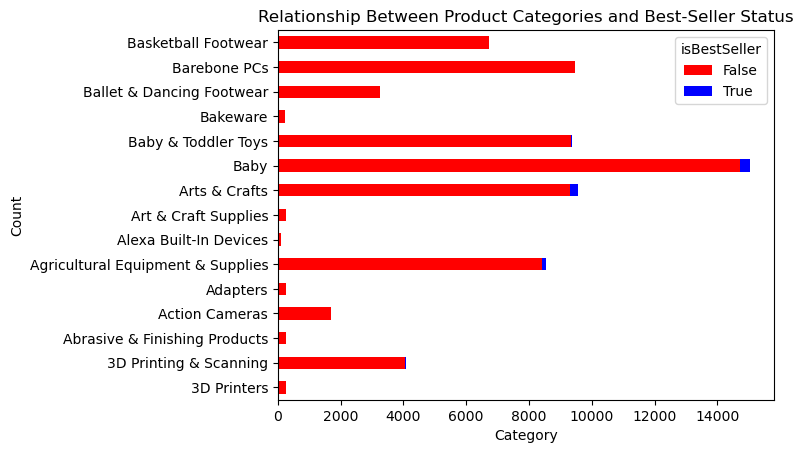

In [26]:
crosstab_result.iloc[0:15].plot(kind="barh", stacked=True, color=['red', 'blue'])
plt.title('Relationship Between Product Categories and Best-Seller Status')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

The chart illustrates the dominance of best-sellers in Baby category. There is a low association between two parameters, we may assume that product category tends to have some influence on number of best-seller in it but it is not a strong determinant.



### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

 **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Calculating the first quartile (Q1) and third quartile (Q3) for the data

In [33]:
Q1 = df['price'].quantile(0.25)
Q1

9.99

In [32]:
Q3 = df['price'].quantile(0.75)
Q3

45.99

In [35]:
IQR = Q3 - Q1
IQR

36.0

In [37]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
lower_bound, upper_bound

(-44.01, 99.99000000000001)

In [39]:
def tukeys_test_outliers(data, method='bounds'):
    Q1 = data.quantile(0.25)
    Q2 = data.quantile(0.5)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    if method == 'identify':
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        return outliers
    elif method == 'bounds':
        data_adjusted = [upper_bound if x > upper_bound else lower_bound if x < lower_bound else x for x in data]
    elif method == 'median':
        data_adjusted = [Q2 if x > upper_bound else Q2 if x < lower_bound else x for x in data]
    elif method == 'remove':
        data_adjusted = data[(data >= lower_bound) & (data <= upper_bound)]
        
    return data_adjusted

In [40]:
def remove_outliers(df, columns_to_parse, outlier_strictness = 1.5):
    columns_to_parse = ['price']
    # error handling to confirm columns_to_parse is a list

    for c in columns_to_parse:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - outlier_strictness * IQR
        upper_bound = Q3 + outlier_strictness * IQR

        df = df[(df[c] >= lower_bound) & (df[c] <= upper_bound)]

    return df

In [42]:
data_series = df['price'] 
outliers = tukeys_test_outliers(data_series)

In [44]:
modified_df = remove_outliers(df, ['price'])

In [45]:
modified_df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


<Axes: >

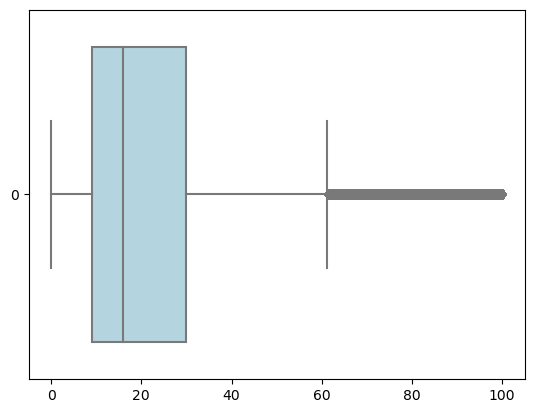

In [46]:
sns.boxplot(data = modified_df['price'], color="lightblue", orient='h')

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories

<Axes: xlabel='category', ylabel='price'>

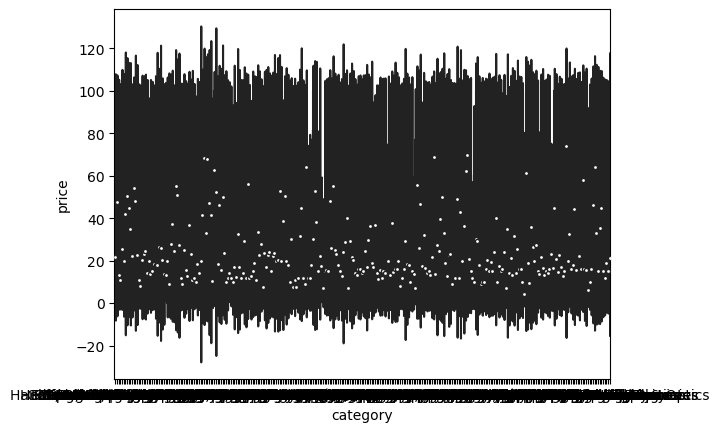

In [97]:
sns.violinplot(data=modified_df, x='category', y='price', palette="Blues")

In [49]:
top_df = modified_df[modified_df['category'].isin(modified_df['category'].value_counts().nlargest(20).index)]

<Axes: xlabel='price', ylabel='category'>

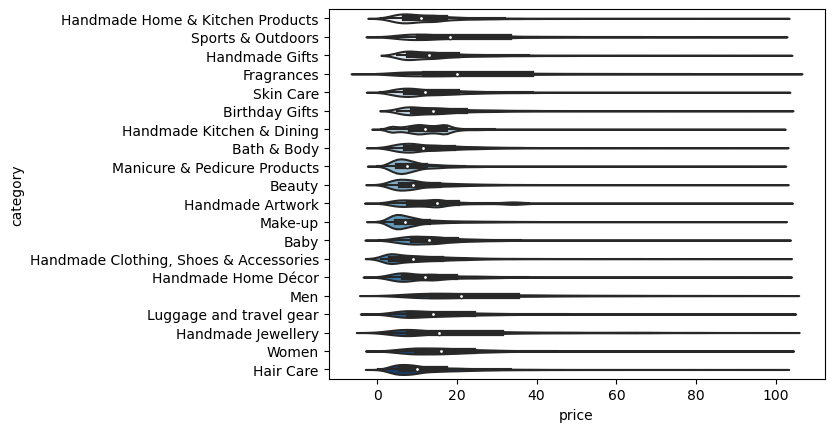

In [50]:
sns.violinplot(data=top_df, x='price', y='category', palette="Blues")

Fragrance product category tends to have the highest median price

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

In [53]:
top_df = modified_df[modified_df['category'].isin(modified_df['category'].value_counts().nlargest(10).index)]

<Axes: xlabel='price', ylabel='category'>

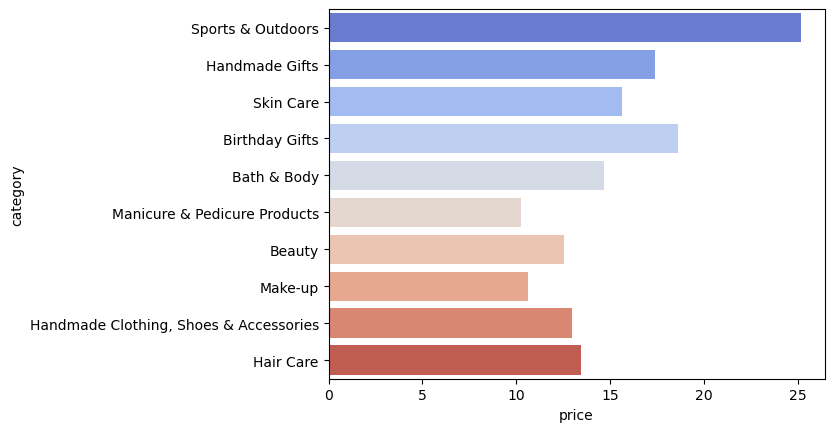

In [55]:
sns.barplot(data=top_df, x='price', y='category', palette="coolwarm", errorbar=None)

In [56]:
highest_price = modified_df.groupby('category')['price'].mean().sort_values(ascending=False)
highest_price

category
Motherboards             68.772432
Boxing Shoes             67.417803
Desktop PCs              66.915562
Tablets                  66.552971
Graphics Cards           65.103509
                           ...    
Bedding Accessories       8.835220
Adapters                  8.750197
Signs & Plaques           8.210513
Arts & Crafts             8.006540
Office Paper Products     6.876369
Name: price, Length: 296, dtype: float64

The highest average price commands 'Motherboards' category

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [59]:
top_df = modified_df[modified_df['category'].isin(modified_df['category'].value_counts().nlargest(10).index)]

<Axes: xlabel='stars', ylabel='category'>

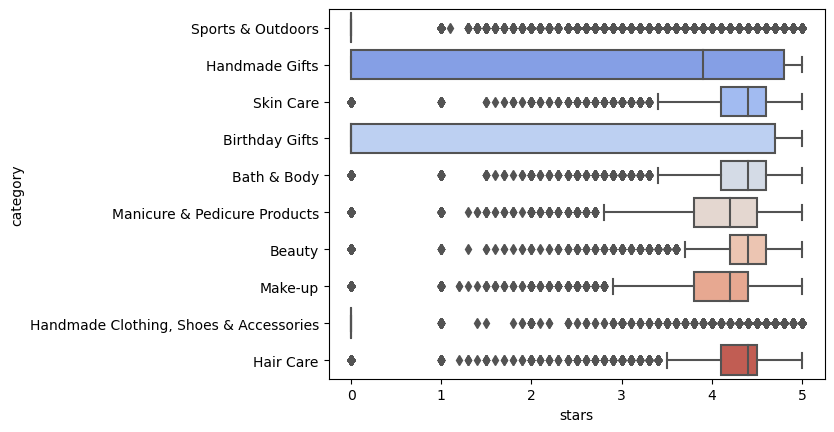

In [60]:
sns.boxplot(data=top_df, x='stars', y='category', palette="coolwarm")

<Axes: xlabel='stars', ylabel='category'>

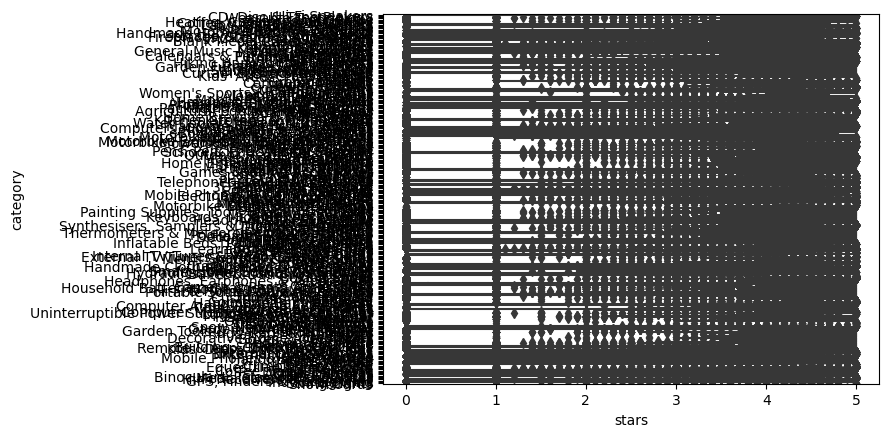

In [79]:
sns.boxplot(data=modified_df, x='stars', y='category', palette="coolwarm")

In [82]:
median_stars = df.groupby('category')['stars'].median().sort_values(ascending=False)
median_stars

category
Computer Memory                4.7
Hobbies                        4.6
Beer, Wine & Spirits           4.6
Laptop Accessories             4.6
Kids' Play Figures             4.6
                              ... 
KVM Switches                   0.0
Karaoke Equipment              0.0
Lab & Scientific Products      0.0
Laptops                        0.0
eBook Readers & Accessories    0.0
Name: stars, Length: 296, dtype: float64

'Computer Memory' category receives the highest median rating from customers. 

### Part 3: Investigating the Interplay Between Product Prices and Ratings

Analyze how product ratings (`stars`) correlate with product prices

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [66]:
# Calculating the Pearson correlation coefficient between 'price' and 'stars' columns
correlation = modified_df['price'].corr(modified_df['stars'])
correlation

-0.07767299878181444

In [65]:
# Calculating the Spearman rank correlation between 'price' and 'stars' 
correlation = modified_df['price'].corr(modified_df['stars'], method='spearman')
correlation

-0.06679697280768455

Pearson Correlation: (-0.08)
Spearman Correlation: (-0.07)


The Pearson correlation of (-0.08) suggests a very low (little if any) negative linear relationship between the product price and product rating. As the price increases, the rating tends to decrease.

The Spearman correlation of (-0.07) indicates a minor negative monotonic relationship between the two variables.

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

<Axes: xlabel='price', ylabel='stars'>

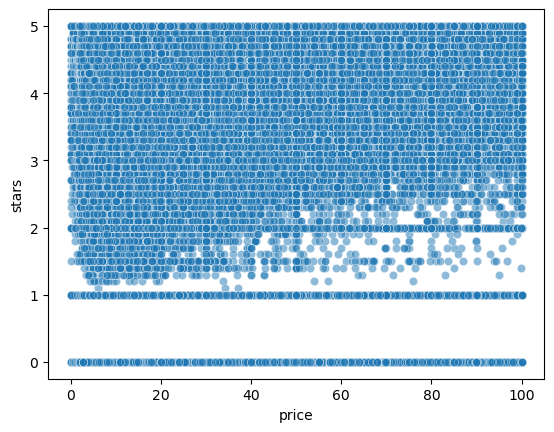

In [70]:
sns.scatterplot(data=modified_df, x='price', y='stars', alpha=0.5)

We can observe that the pricier the product - the less low ratings it receives.

- Use a correlation heatmap to visualize correlations between all numerical variables.

In [87]:
potential_categorical_from_numerical = modified_df.select_dtypes("number").loc[:, modified_df.select_dtypes("number").nunique() < 20]
potential_categorical_from_numerical

""
0
1
2
3
4
...
2443646
2443647
2443648
2443649


In [88]:
df_numerical = modified_df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

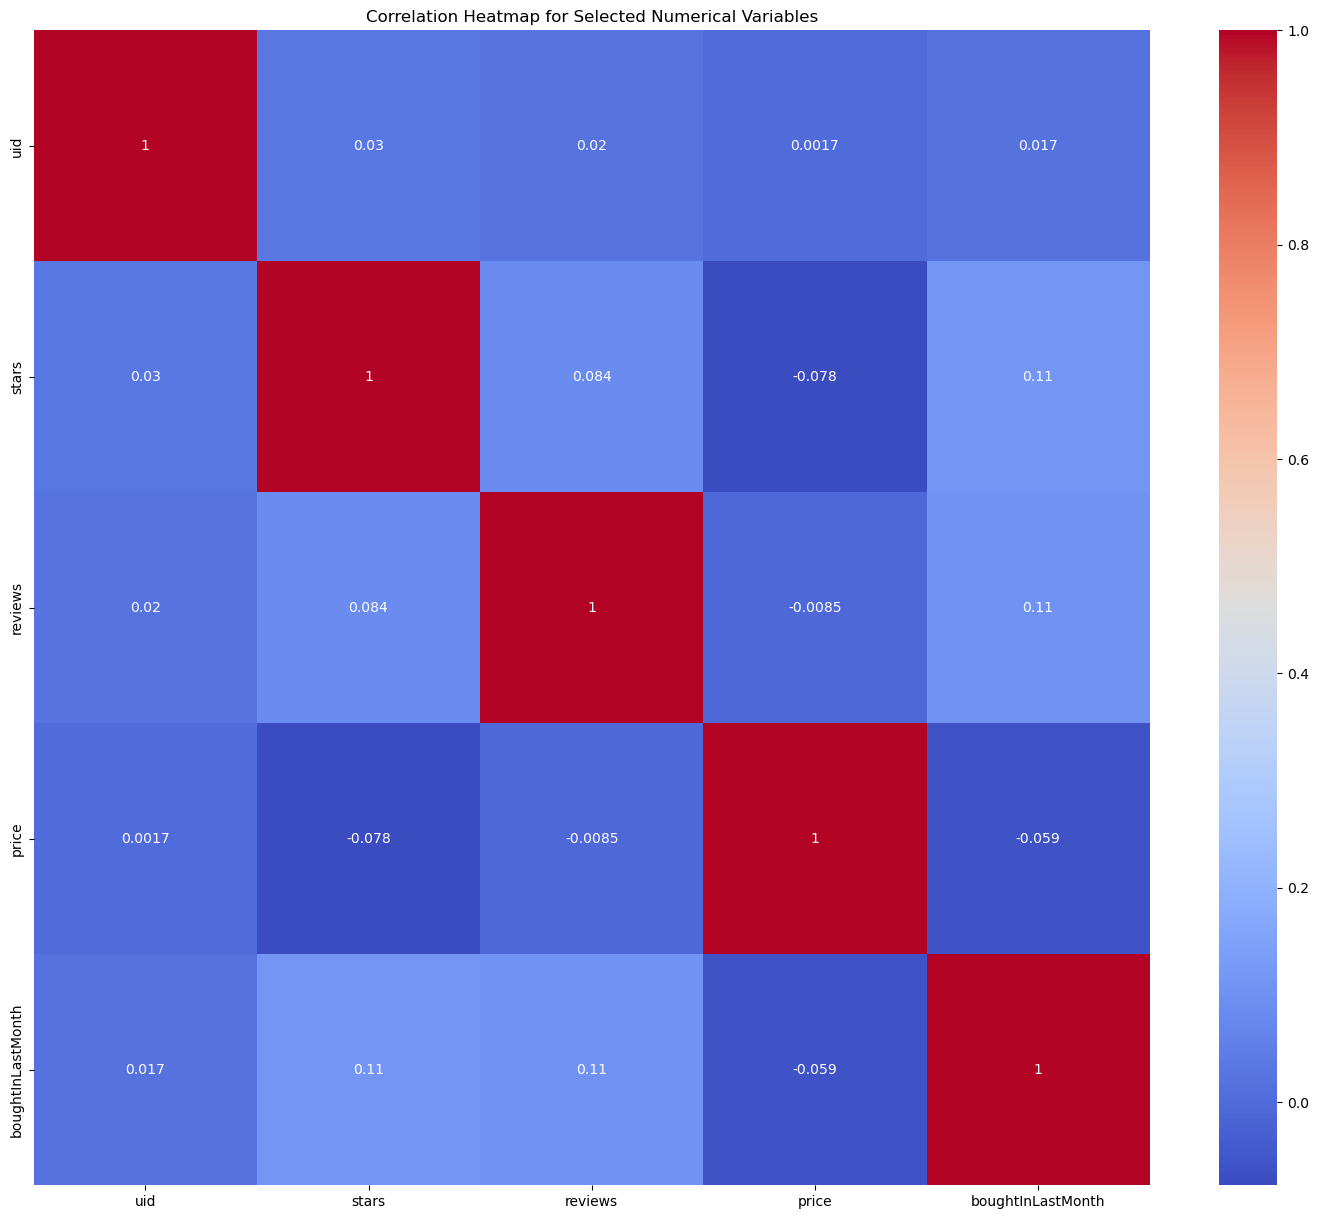

In [89]:
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()


Patterns here barely can me observed, we may asssume that that there is a slight positive correlation between product price and ratings.

- Examine if product prices typically follow a normal distribution using a QQ plot.

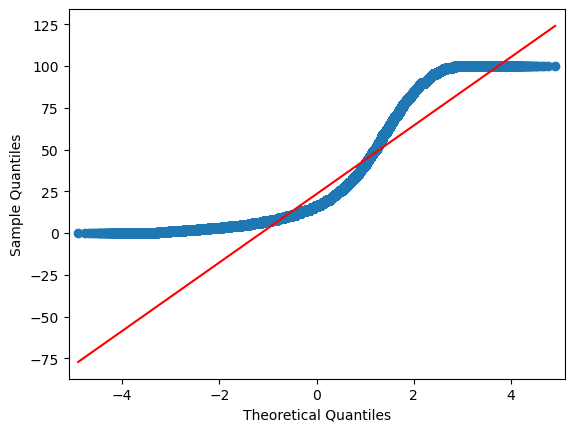

In [92]:
import statsmodels.api as sm

sm.qqplot(modified_df['price'], line='s');

It is hard to define skeweness, on both tails data points deviate significantly from red line. This indicates that there is more extreme
high values than is expected in normal distribution. The central portion of the data points doesn't align perfectly with the line means possible deviations from normality.
The 'price' data is not normally distributed